In [66]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

In [67]:
cache_dir = '/tf/Datasets/keras'
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True, cache_dir=cache_dir)

In [68]:
flowers_root = pathlib.Path(flowers)

In [69]:
os.listdir(flowers_root)

['sunflowers', 'daisy', 'LICENSE.txt', 'tulips', 'dandelion', 'roses']

In [70]:
os.listdir(pathlib.Path(flowers_root, 'sunflowers'))[:2]

['18097401209_910a46fae1_n.jpg', '4528959364_fa544b0f4e_m.jpg']

In [71]:
import glob, fnmatch
files = glob.glob(str(flowers_root) + '/**/*', recursive=True)

In [72]:
files[:10]

['/home/appuser/.keras/datasets/flower_photos/sunflowers',
 '/home/appuser/.keras/datasets/flower_photos/daisy',
 '/home/appuser/.keras/datasets/flower_photos/LICENSE.txt',
 '/home/appuser/.keras/datasets/flower_photos/tulips',
 '/home/appuser/.keras/datasets/flower_photos/dandelion',
 '/home/appuser/.keras/datasets/flower_photos/roses',
 '/home/appuser/.keras/datasets/flower_photos/sunflowers/18097401209_910a46fae1_n.jpg',
 '/home/appuser/.keras/datasets/flower_photos/sunflowers/4528959364_fa544b0f4e_m.jpg',
 '/home/appuser/.keras/datasets/flower_photos/sunflowers/287233531_74d4605814_m.jpg',
 '/home/appuser/.keras/datasets/flower_photos/sunflowers/3815322974_52c12dbde3.jpg']

In [73]:
jpeg_files = [fn for fn in files if fnmatch.fnmatch(fn, '*.jpg')]
len(jpeg_files)

3670

In [74]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [11]:
for file in list_ds.take(2):
    print(file.numpy())

b'/home/appuser/.keras/datasets/flower_photos/dandelion/4675287055_5938ed62c4.jpg'
b'/home/appuser/.keras/datasets/flower_photos/dandelion/6901435398_b3192ff7f8_m.jpg'


2024-05-03 07:00:59.969875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Split list datasets

In [75]:
dataset_size = len(list_ds)
dataset_size

3670

In [76]:
validation_size = int(0.2 * dataset_size)
train_list_ds = list_ds.skip(validation_size)
valid_list_ds = list_ds.take(validation_size)

## Create image datasets

In [77]:
batch_size = 32
img_height = 180
img_width = 180

### Read images

In [78]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
vocab = np.unique(['sunflowers', 'daisy', 'tulips', 'dandelion', 'roses'])
lookup_layer = tf.keras.layers.StringLookup(vocabulary=vocab, num_oov_indices=0)
onehot_layer = tf.keras.layers.CategoryEncoding(
    num_tokens=lookup_layer.vocabulary_size(),
    output_mode="one_hot")

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]
  label = lookup_layer(label)
  # label = onehot_layer(label)
    
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [img_height, img_width])
  return image, label

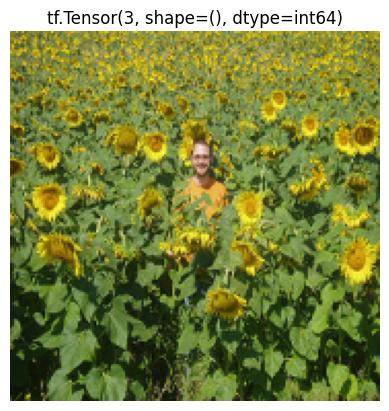

In [79]:
file_path = next(iter(train_list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

show(image, label)

In [80]:
train_ds = train_list_ds.map(parse_image)
valid_ds = valid_list_ds.map(parse_image)
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(180, 180, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [81]:
def get_min_max_of_img(img_np: np.array):
  img_np = img_np.reshape([-1])
  return(img_np.min(), img_np.max())

(0.0, 0.99213654)


2024-05-03 07:32:25.870308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


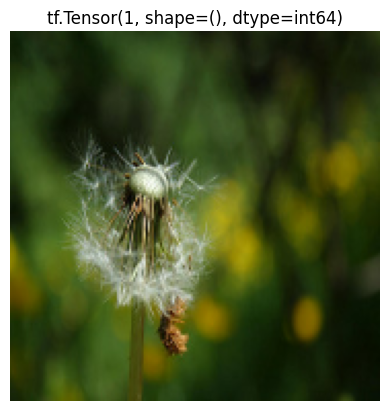

In [82]:
for image, label in train_ds.take(1):
  print(get_min_max_of_img(image.numpy()))
  show(image, label)

### Rotate images

In [305]:
import scipy.ndimage as ndimage

@tf.py_function(Tout=tf.float32)
def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image
    
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  rotated_image = random_rotate_image(image)
  # Ensure pixel values are within [0, 1] range
  rotated_image = tf.clip_by_value(rotated_image, 0.0, 1.0)  
  rotated_image.set_shape(im_shape)
  return rotated_image, label

In [315]:
train_rot_ds = train_ds.map(tf_random_rotate_image)
train_rot_ds

<_MapDataset element_spec=(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [309]:
for image, label in train_rot_ds.take(1):
  print(get_min_max_of_img(image.numpy()))
  # show(image, label)

# for image, label in valid_ds.take(1):
#   show(image, label)

(0.0, 1.0)


2024-04-21 07:45:01.556267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([0.2267, 0.1525, 0.0761], dtype=float32), 1)

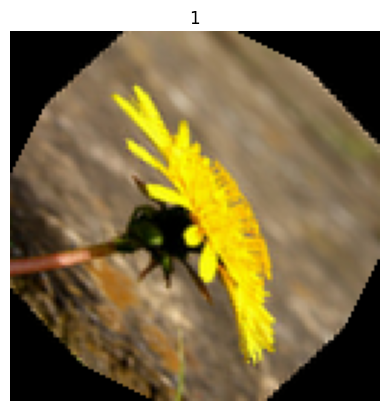

In [310]:
sample = next(iter(train_rot_ds.take(1)))
show(*sample)
sample[0][60][0].numpy(), sample[1].numpy()

## Prepare datasets

In [94]:
AUTOTUNE = tf.data.AUTOTUNE

# train_bat_ds = train_rot_ds.repeat(2).shuffle(buffer_size=100).batch(batch_size)
train_bat_ds = train_ds.repeat(2).shuffle(buffer_size=100).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
valid_bat_ds = valid_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
# train_bat_ds = train_ds.batch(batch_size)
# valid_bat_ds = valid_ds.batch(batch_size)

In [95]:
data = next(iter(train_bat_ds.take(1)))[0]
data.shape

2024-05-03 07:40:39.742835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorShape([32, 180, 180, 3])

## Create a model

In [96]:
steps_per_epoch = len(train_bat_ds)
steps_per_epoch

184

In [106]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=steps_per_epoch*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [123]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation="tanh", input_shape=(180,180,3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(32, (3, 3), activation="tanh"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="tanh"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="tanh"),
        tf.keras.layers.Dense(5)
    ])

    model.compile(
        optimizer="adam",
        # optimizer=get_optimizer(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='SCCE'),
            "accuracy",        
            # tf.keras.metrics.Precision(name='precision'),
            # tf.keras.metrics.Recall(name='recall'),
        ]
    )

    return model

model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,157 (12.59 MB)

 Trainable params: 3,301,157 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

## Save checkpoints during training

In [124]:
checkpoint_path = "training_2/flower_classification.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## Train the model

In [130]:
# if there is a saved checkpoint, load the weights from it
model.load_weights(checkpoint_path)

In [ ]:
history = model.fit(
    train_bat_ds,
    validation_data=valid_bat_ds,
    epochs=100,
    callbacks=[checkpoint_cb]
    # callbacks=[checkpoint_cb, early_stopping_cb]
)

## Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.5625
[1 0 4 0 0 0 1 0 1 1 2 1 0 3 1 0 3 2 2 3 3 1 3 2 2 0 0 1 0 2 3 1]
[0 0 2 0 0 3 1 0 4 1 4 4 0 3 0 4 4 2 4 3 3 3 3 4 2 0 2 1 0 2 3 0]
dandelion wrong... in fact daisy
tulips wrong... in fact roses
daisy wrong... in fact sunflowers
dandelion wrong... in fact tulips
roses wrong... in fact tulips
dandelion wrong... in fact tulips
dandelion wrong... in fact daisy
daisy wrong... in fact tulips
sunflowers wrong... in fact tulips
roses wrong... in fact tulips
dandelion wrong... in fact sunflowers
roses wrong... in fact tulips
daisy wrong... in fact roses
dandelion wrong... in fact daisy


2024-05-03 08:48:45.696842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


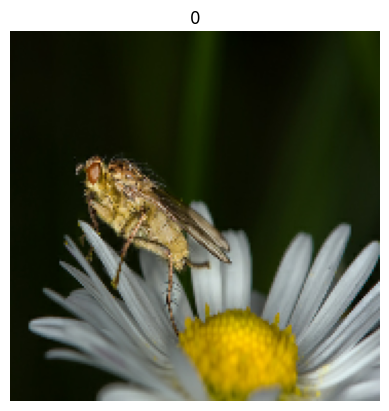

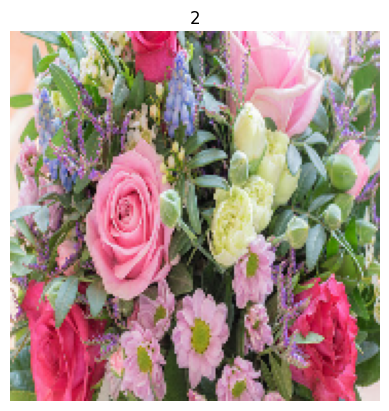

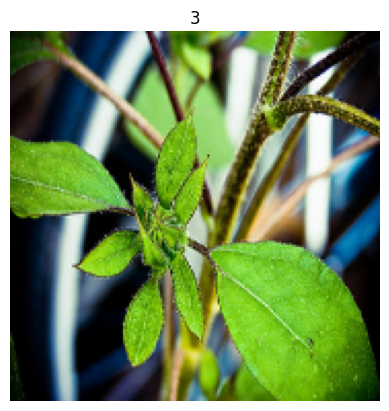

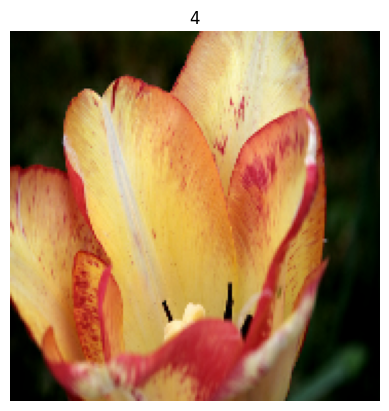

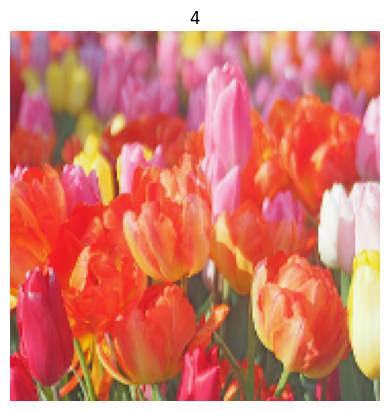

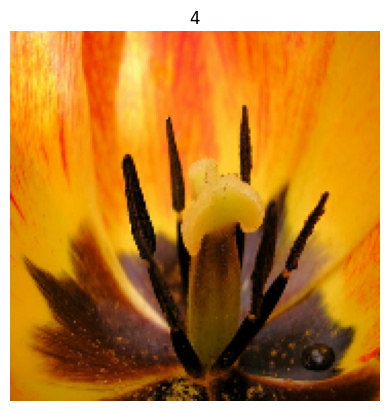

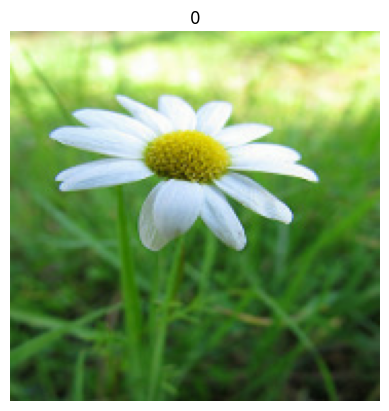

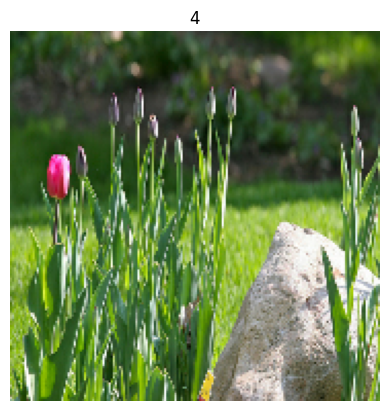

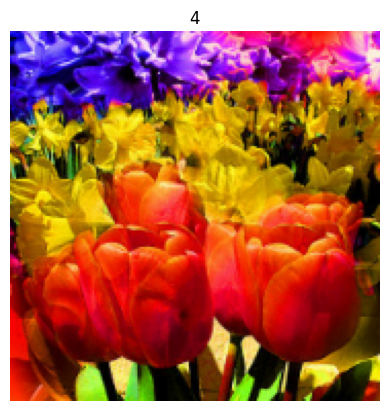

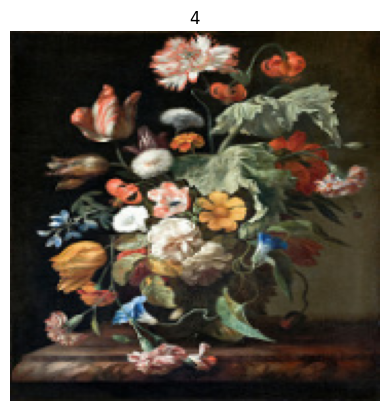

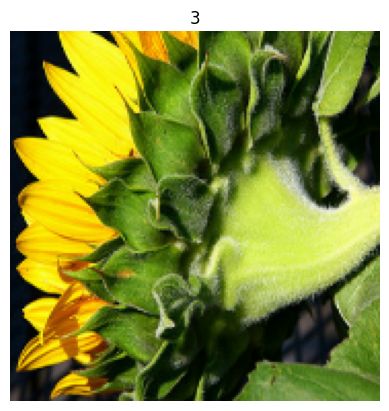

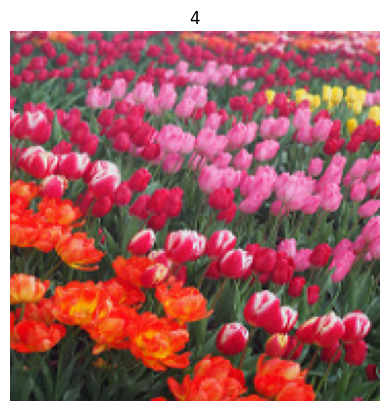

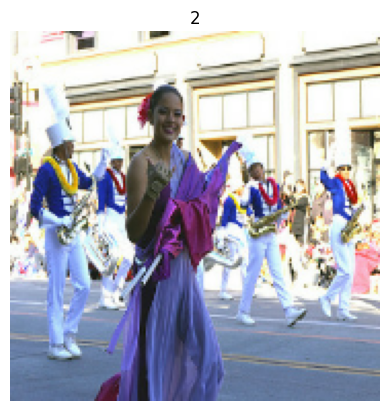

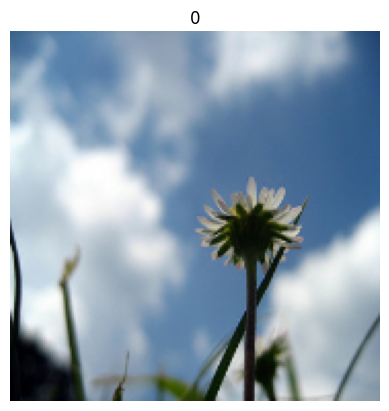

In [137]:
for images, labels in valid_ds.batch(32).take(1):
    predictions = model.predict(images)
    pred = np.argmax(predictions, axis=1)
    true = labels.numpy()
    mask = pred != true

    print((mask.size - mask.sum()) / mask.size)
    print(pred)
    print(true)

    wrong_pred = pred[mask]
    correct = true[mask]
    false_imgs = images[mask]
    for w, c, i in zip(wrong_pred, correct, false_imgs):
        print(f'{vocab[w]} wrong... in fact {vocab[c]}')
        show(i, c)